<div>
<img src="./images/NCI_Australia_logo.png" width="300" align="left"/>
</div>


# Using GSKY's WCS in Python


### Requesting data subsets through NCI's GSKY Data Server 
NCI's GSKY Data Server supports the Open Geospatial Consortium (OGC) Web Coverage Service (WCS), which is a standard protocol for serving geospatial data in common formats such as NetCDF and GeoTIFF.  

**The following libraries will need to be imported for the below example.** 

In [1]:
from owslib.wcs import WebCoverageService
from PIL import Image
%matplotlib inline

**To start, we will need the base GSKY server URL:**

In [2]:
gsky_url = 'http://gsky.nci.org.au/ows/dea'

**Now using OWSLib, we can begin by inspecting the service metadata:**


In [3]:
wcs = WebCoverageService(gsky_url, version='1.0.0')

**Find out the available data layers that can be requested:**

In [4]:
for layer in list(wcs.contents):
    print ("Layer Name:", layer)
    print ("Title:", wcs[layer].title, '\n')

Layer Name: blend_sentinel2_landsat_nbart_daily
Title: Multi-sensor (Landsat and Sentinel 2) surface reflectance (Beta) 

Layer Name: hltc_high
Title: DEA High Tide Composite 25m v2.0 

Layer Name: hltc_low
Title: DEA Low Tide Composite 25m v2.0 

Layer Name: item_relative
Title: DEA Intertidal Extents Model Relative Layer 25m v2.0 

Layer Name: item_stddev
Title: DEA Intertidal Extents Model Confidence Layer 25m v2.0 

Layer Name: landsat5_geomedian
Title: DEA Landsat 5 terrain corrected surface reflectance geometric median 

Layer Name: landsat5_nbar_16day
Title: 16-day DEA Landsat 5 surface reflectance 

Layer Name: landsat5_nbar_daily
Title: Daily DEA Landsat 5 surface reflectance 

Layer Name: landsat5_nbart_16day
Title: 16-day DEA Landsat 5 terrain corrected surface reflectance 

Layer Name: landsat5_nbart_daily
Title: Daily DEA Landsat 5 terrain corrected surface reflectance 

Layer Name: landsat7_geomedian
Title: DEA Landsat 7 terrain corrected surface reflectance geometric med

**We can also view metadata that is available about a selected layer. For example, you can view the abstract associated with that data layer.** 

In [5]:
layer = "landsat8_nbar_16day"

In [6]:
print(wcs[layer].abstract)

This product has been corrected to remove the influences of the atmosphere, the time of year and satellite view angles using the methods described in Li et al. 2010 https://doi.org/10.1109/JSTARS.2010.2042281. Landsat 8 Operational Land Imager (OLI) data is available from March 2013 and onwards. More detailed information about the surface reflectance product suite produced using Digital Earth Australia including CCBY4.0 is available at http://dx.doi.org/10.4225/25/5a7a501e1c5af. This service provides access to Landsat 8 OLI surface reflectance data. The image composites are made from images acquired within a 16 day period, and may include clouds.


In [7]:
print(wcs[layer].styles)

None


**Or view the CRS options, bounding box, and time positions available (these details will be needed to construct the GetMap request).** 

In [8]:
print ("CRS Options: ")
crs = sorted(wcs[layer].supportedCRS)
print ('\t', crs, '\n')
    
print ("Bounding Box: ")
bbox = wcs[layer].boundingBoxWGS84
print ('\t', bbox, '\n')
    
print ("Time Positions: ")
time = wcs[layer].timepositions
print ('\t', time[-10:], '\n')

CRS Options: 
	 [urn:ogc:def:crs:EPSG::4326] 

Bounding Box: 
	 (-180.0, -90.0, 180.0, 90.0) 

Time Positions: 
	 ['2019-11-15T00:00:00.000Z', '2019-12-01T00:00:00.000Z', '2019-12-17T00:00:00.000Z', '2020-01-02T00:00:00.000Z', '2020-01-18T00:00:00.000Z', '2020-02-03T00:00:00.000Z', '2020-02-19T00:00:00.000Z', '2020-03-06T00:00:00.000Z', '2020-03-22T00:00:00.000Z', '2020-04-07T00:00:00.000Z'] 



**Let's use the information above to construct and make GetCoverage requests.**

The below sections will demonstrate both a request in GeoTIFF and NetCDF formats.

**We'll need to define a bounding box for our request:**

In [9]:
subset_bbox = (137,-37,139,-35)

**OWSLib's library can now be used to make the GetCoverage request:**

In [10]:
output = wcs.getCoverage(identifier=layer, Styles='fc', 
                         time=[wcs[layer].timepositions[6]],
                         bbox=subset_bbox,format='GeoTIFF',
                         crs='EPSG:4326', width=256, height=256)

**To view the above constructed URL:**

In [11]:
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=137%2C-37%2C139%2C-35&time=2013-06-23T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=GeoTIFF&width=256&height=256&Styles=fc


**Write the result to a file:**

In [12]:
filename = './output/gsky_wcs.tiff'
with open(filename, 'wb') as f:
    f.write(output.read())

**And if we'd like to confirm the result, we can open and view the GeoTIFF with the Python GDAL library for example:**

In [13]:
import gdal
import matplotlib.pyplot as plt 
%matplotlib inline

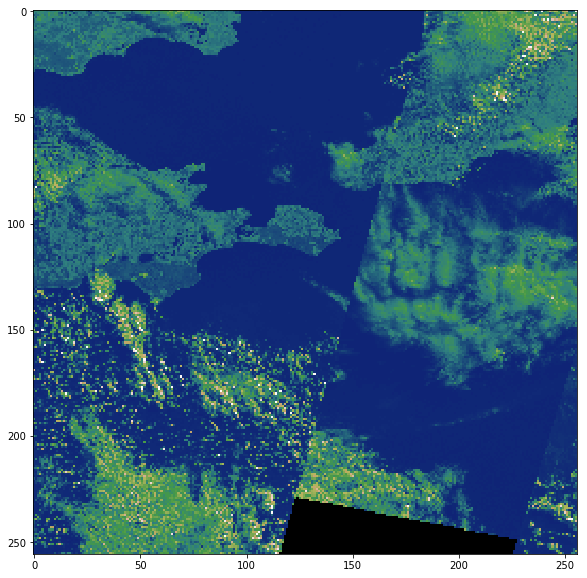

In [14]:
ds = gdal.Open(filename)
band = ds.GetRasterBand(1).ReadAsArray()

fig = plt.figure(figsize=(10,10))
plt.imshow(band, cmap='gist_earth')

**To request a coverage returned as in the NetCDF format, a similar GetCoverage request is constructed with the format parameter now specifying the NetCDF option.** 

In [15]:
subset_bbox = (137,-37,139,-35)

output = wcs.getCoverage(identifier=layer, Styles='tc', 
                         time=[wcs[layer].timepositions[6]],
                         bbox=subset_bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

In [16]:
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=137%2C-37%2C139%2C-35&time=2013-06-23T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=tc


**Again, write the output to a file to save:**

In [17]:
filename = './output/gsky_wcs.nc'
with open(filename, 'wb') as f:
    f.write(output.read())

**To confirm or inspect the contents of the NetCDF file, libraries such as NetCDF4 Python or GDAL can be used.** 

In [18]:
from netCDF4 import Dataset
import numpy as np

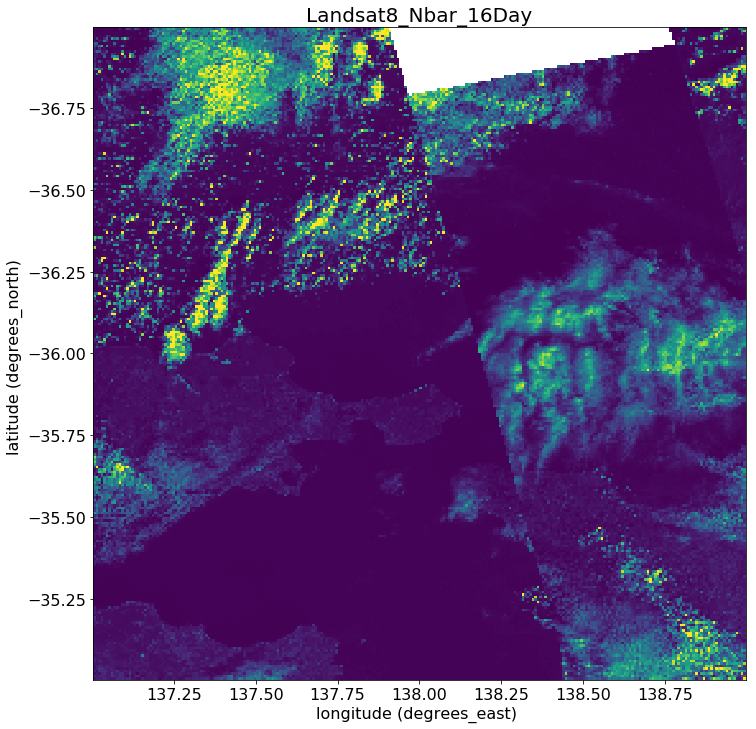

In [19]:
with Dataset(filename) as ds:
    
    band = ds['Band1']
    lon = ds['lon']
    lat = ds['lat']


    # Set figure size
    plt.figure(figsize=(12,12))

    # Plot image
    plt.imshow(band, extent=[lon[0], lon[-1], lat[-1], lat[0]])

    # Add figure title and labels
    # We can make use of the defined variable attributes to do this
    plt.title(layer.title(), fontsize=20)
    plt.xlabel(lon.long_name+' ('+lon.units+') ', fontsize=16)
    plt.ylabel(lat.long_name+' ('+lat.units+') ', fontsize=16)


    # Adjust tick mark size
    plt.tick_params(labelsize=16)

<br>
<br>
<br>


--------
**For more information on the OGC WCS standard specifications and the Python OWSLib package:** <br/>
http://www.opengeospatial.org/standards/wcs <br/>
https://geopython.github.io/OWSLib/#wms <br/>
